# Intro & context
This notebook serves to prototype and test ensemble Kalman filter code for assimilation of evapotranspiration (ET) data with an ET model and various noisy data inputs. We can try to assimilate data for air and surface temperature and net radiation with measurements of ET from either (a) a flux tower in Mississippi or (b) synthetic ET flux tower data, within the SSEBop ET model (Senay et al., 2013). This model is relatively simple to apply, has been shown to have better performance than the MODIS MOD16 product, and the primary developer (Gabriel Senay) is a collaborator who may be interested in data assimilation for SSEBop. After getting the code working for predictions at a point location, we could expand to a grid (small to large) where not all grid cells have a flux tower. Eventually the idea for ET is to not only have data assimilated outputs for SSEBop model parameters and ET values, but to assimilate different models for ET too (like the MOD16, GLEAM, ALEXI, others), to try to overcome significant model structural uncertainties that result from basic uncertainties about ET processes.

## SSEBop ET model
The SSEBop ET model (Senay et al., 2013) was developed out of USGS EROS to be an operationalized version of the common Simplified Surface Energy Balance framework, for quickly producing ET estimates at the CONUS scale. Surface energy balance approaches partition net incoming radiation at the earth's surface into sensible heat flux, ground heat flux, and latent heat flux (water to water vapor -> ET). SSEBop uses predefined hot and cold reference values for each pixel in the CONUS, where the hot reference value is the bare, dry soil end member where all net radiation is converted to sensible heat flux. The cold reference value is the well-watered, highly vegetated end member where all net radiation is converted to latent heat flux. The estimate for ET is then a fraction of the reference ET ($ET_0$) that depends on the hot ($T_h$) and cold ($T_c$) reference temperatures and on surface temperature ($T_s$) as (Eq. 1-2 in Senay 2013):
$$ET = \frac{T_h - T_s}{T_h - T_c} k ET_0$$
where *k* is "a coefficient that scales the grass reference ET into the level of a maximum ET experienced by an aerodynamically rougher crop. A recommended value for *k* is 1.2."

The $T_c$ cold boundary condition (for each pixel) is defined as (Eq. 3-4):
$$T_c = c T_a$$
where *c* is a correction factor with a value of 0.993 and $T_a$ is the near-surface maximum air temperature for the modeled time period.

The $T_h$ hot boundary condition is defined as (Eq. 16):
$$T_h = T_c + \frac{R_n r_{ah}}{\rho_a C_p}$$
where $C_p$ is the specific heat of air at constant pressure (1.013 kJ /kg /degC), and $r_{ah}$ is the aerodynamic resistance to heat flow from a bare, dry surface, calibrated in this paper to be 110 s/m. $\rho_a$ is the air density defined below (Eq. 17):
$$\rho_a = \frac{3.451 P}{T + 273}$$
where *P* is atmospheric pressure in kPa, *Z* is the elevation in meters, and *T* is the mean daily temperature in degC.

The clear-sky net radiation ($R_n$) is the most involved input to calculate (Eq. 7-15 in Senay). It is a function of latitude, solar declination, time of year, maximum and minimum daily temperature, actual vapor pressure, and elevation, and several constants. For the purpose of this filter code development, to keep the number of input data sets down for now, we can just use the values for $R_n$ included in the flux tower data set. (It's a quantity they have to calculate to get the latent heat flux results - so will correlate with the ET measurements, which will be something to consider.)

## Data sets

### Flux tower
The flux tower data processed here is a version of the data for the "US-Goo" station that is reduced for number of variables and length of time (here June - August, 2002). The station is near Goodwin Creek, MS. It's the closest AmeriFlux tower to the MAP region (just outside it). The data are in the formats described here: http://ameriflux.lbl.gov/data/aboutdata/data-variables/ Most relevant for this are:  
TIMESTAMP_START and TIMESTAMP_END, which define the start and end times over which the data points are averaged, in the format YYYYMMDDHHMM  
TA, air temperature, degC  
LE, latent heat flux, W / m^2  
NETRAD, net radiation, W / m^2  
PA, atmospheric pressure, kPa  
"NoData" values are marked -9999

For this notebook, the data have been gathered and processed ('pre_fluxtower_et.py') into a numpy array called "fluxdata", with ~4,000 columns of observations and the following 5 rows: 
timestamp in julian day with fraction, ET (mm/day), TA (air temp in C), PA (atmospheric pressure in kPa), NETRAD (net radiation in W/m^2)

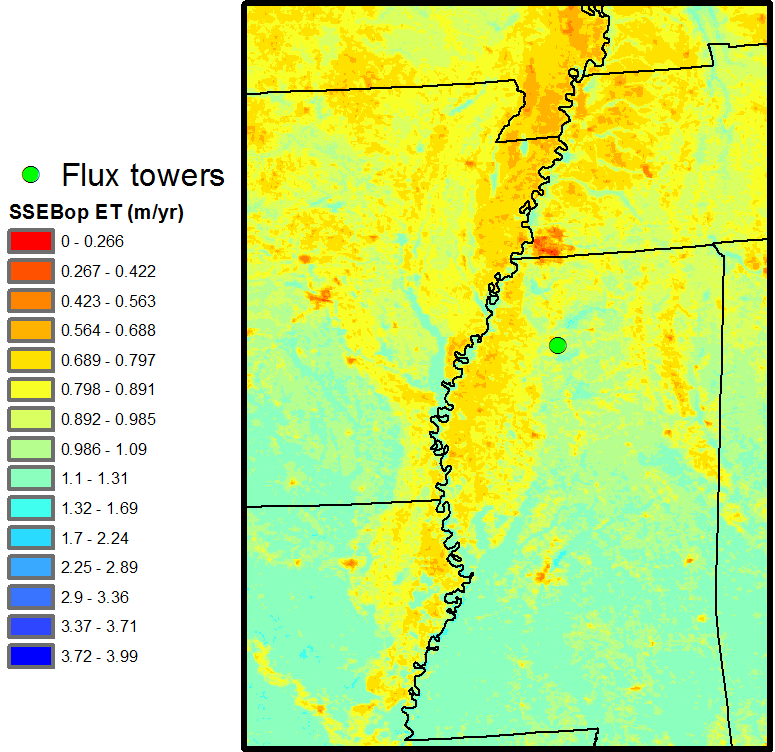

### Surface temperature
For surface temperature, the data used here is the MODIS MOD11A2 product, of 8-day composite average values for both a daytime and a nighttime measurement. The metadata is available at: https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mod11a2_v006

For this notebook, the data have been gathered and processed ('pre_modistemp.py') into arrays for temperature in degrees C ('temp'), times of temperature measurement in julian days including fractions ('temptimes'), and QC data where available in error bounds of degrees when available ('tempqc').

### Reference ET
For reference ET, the MODIS 8-day composite sum was gathered for the MOD16A2 product, for potential ET, which can stand in here for reference ET. Since it was in the same data set, the actual ET estimates (based on the Mu et al. 2011 algorithm) were also gathered; we can either use these or not.

For this notebook, the data have been gathered and processed ('pre_modistemp.py') into a numpy array called "etdata" with rows corresponding to ET, PET, and QC (mostly not available) in mm/8days, and columns corresponding to the 8-day sum measurements starting with the julian day in 'days'.

In [1]:
#pull in data, define constants and model
import numpy as np
import os
import matplotlib.pyplot as mpl

savepath=os.path.dirname(os.path.abspath("__file__")) 

#MODIS satellite data
#Temperature
data=np.load(savepath+'\\MODIS_temp_et2.npz')
temp=data['alltemp']  #land surface temperature in degrees C. One daytime and one nighttime per 8 days. Mmt is in the middle of an 8-day stretch, representing its average.
temptimes=data['allttimes'] #julian day and fraction for the time of measurement. already adjusted to be in the middle of the 8 days.
tempqc=data['allqc'] #error bounds in K. values of 6 represent ">=3K" error from MODIS data. Lot of NaN values.

#PET and ET
#Units for the below: ET and PET data are totals over the 8 days following the julian date. In mm/8day.
#  QC is quality control, says non-cloudy for all but one point here. 
modisetall=data['etdata']
modiset=modisetall[0]
modispet=modisetall[1]
modisetqc=modisetall[2]
modetdays=data['days']  #these are the julian days for modis ET
modetdays+=4 #adjust the observations to halfway within the 8 day window

# flux tower ET data
#rows: timestamp in julian day with fraction, ET (mm/day), TA (air temp in C), PA (atmospheric pressure in kPa), NETRAD (net radiation in W/m^2)
data2=np.load(savepath+'\\fluxtower_et.npz')
fluxdata=data2['fluxdata']

#constants in model
c=0.993 #dimless correction factor
C_p=1.013 # kJ/kg/degC
r_ah=110 # s/m, calibrated in Senay paper
k=1.3 #correction factor scaling ref ET to rougher croups

def ssebop(Ts,refET,Ta,Pa,Rn):     
    airdensity=3.451*Pa/(Ta+273)
    Tc=c*Ta
    Th=Tc+Rn*r_ah/(airdensity*C_p)
    ET=(Th-Ts)*k*refET/(Th-Tc)
    return(ET)

# Ensemble Kalman filter
The idea is to try to put together a code to implement the ensemble Kalman filter to process this ET data (and/or synthetic data). The algorithm followed below is outlined in Evenson (2009), starting with Eq. 49.

(the below is not yet functional..)

In [ ]:
# Parameters
N = 100 # number of ensemble members
n = 1 # size of the model state vector. Is this just 1 for ET, or multiple for ET, Temp, etc?
d0 = fluxdata[1] #array of observations through time. here starting with flux tower ET data in mm/day
sigma_d0=0.25*np.mean(d0) # ?  describe unknown mmt error distribution... wrote here 25% of mean
M=np.ones((len([d0[0]]),n)) # the measurement operator that maps the model state to the measurements d. If ET is both modeled and measured, ones.

ens_evol=np.ndarray((n,N,len(fluxdata[1]))) # to track the ensemble through time.

#Initialize ensemble based on first data point.
d=d0[0]+sigma_d0*np.random.randn(N)
ens_evol[0,:,0]=d #for multiple modeled variables, need to initialize them all

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx
    
for i in range(len(fluxdata[1])-1):
    d0 = [fluxdata[1][i+1]] #array of observations this timestep. here starting with just flux tower ET data in mm/day

    #Forecast step (using model to predict next timestep)
    state=ens_evol[0,:,i]
    A=np.ndarray((n,N))  #rows of the variables, columns of the ensemble members
    for j in range(len(state)):
        #surface temperature and refET... are at different timesteps. for now just find the closest one to this timestep ?   
        Tsurf=temp[find_nearest(temptimes,fluxdata[0][i+1])]
        refET=modispet[find_nearest(modetdays,fluxdata[0][i+1])]
        prediction=ssebop(Ts=Tsurf,refET=refET/8, Ta=fluxdata[2][i+1],Pa=fluxdata[3][i+1],Rn=fluxdata[4][i+1])        
        A[:,j]=prediction
    
    #Analysis step (incorporating mmt to get posterior distribution)
    # following Eqs 49-63 in Evenson 2009
    # Ensemble representation of the covariance
    Abar=np.dot(A,np.identity(N)/N)   # ensemble mean stored in each column of Abar
    Aprime=A-Abar    # ensemble perturbation matrix
    Cens=1./(N-1)*np.dot(Aprime,np.transpose(Aprime))  # ensemble covariance matrix
    
    # Measurement perturbations
    D=np.ndarray(shape=(len(d0),N)) #N vectors of perturbed observations
    E=np.ndarray(shape=(len(d0),N)) #ensemble of perturbations
    for j in range(N):    
        eps=sigma_d0*np.random.randn(len(d0))
        D[:,j]=d0+eps   #measurements + perturbations
        E[:,j]=eps
    Cerr=1./(N-1)*np.dot(E,np.transpose(E))   # error covariance matrix
    
    # Analysis equation
    #Aa=A+np.dot(np.dot(np.dot(Cens,np.transpose(M)),np.linalg.inv(np.dot(np.dot(M,Cens),np.transpose(M))+Cerr)),(d-np.dot(M,A))) # d in Eq 57 is if you do one ensemble member at a time
    #alternatively,
    Dprime=D-np.dot(M,A)
    S=np.dot(M,Aprime)
    C=np.dot(S,np.transpose(S))+ (N-1)*Cerr # Cerr note: either exact full-rank covar matrix or low-rank (ensemble) matrix
    X=np.identity(N)/N + np.dot(np.dot(np.transpose(S),np.linalg.inv(C)),Dprime)
    Aa=np.dot(A,X)

    ens_evol[:,:,i+1] = Aa

ens_mean=np.mean(ens_evol[:,:,:],axis=1)

mpl.figure() 
mpl.xlabel('Time in Julian days') 
mpl.ylabel('Filtered ET prediction, mm/day')
mpl.scatter(fluxdata[0],ens_mean)


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars


In [3]:
# Below is the code of FilterPy's ensemble Kalman filter.
# The author acknowledges limitations.

#Init signature: EnKF(self, x, P, dim_z, dt, N, hx, fx)
class EnKF(object):
    """ This implements the ensemble Kalman filter (EnKF). The EnKF uses
    an ensemble of hundreds to thousands of state vectors that are randomly
    sampled around the estimate, and adds perturbations at each update and
    predict step. It is useful for extremely large systems such as found
    in hydrophysics. As such, this class is admittedly a toy as it is far
    too slow with large N.

    There are many versions of this sort of this filter. This formulation is
    due to Crassidis and Junkins [1]. It works with both linear and nonlinear
    systems.

    References
    ----------

    - [1] John L Crassidis and John L. Junkins. "Optimal Estimation of
      Dynamic Systems. CRC Press, second edition. 2012. pp, 257-9.
    """

    def __init__(self, x, P, dim_z, dt, N, hx, fx):
        """ Create a Kalman filter. You are responsible for setting the
        various state variables to reasonable values; the defaults below will
        not give you a functional filter.

        Parameters
        ----------

        x : np.array(dim_z)
            state mean

        P : np.array((dim_x, dim_x))
            covariance of the state

        dim_z : int
            Number of of measurement inputs. For example, if the sensor
            provides you with position in (x,y), dim_z would be 2.

        dt : float
            time step in seconds

        N : int
            number of sigma points (ensembles). Must be greater than 1.

        hx : function hx(x)
            Measurement function. May be linear or nonlinear - converts state
            x into a measurement. Return must be an np.array of the same
            dimensionality as the measurement vector.

        fx : function fx(x, dt)
            State transition function. May be linear or nonlinear. Projects
            state x into the next time period. Returns the projected state x.

        Examples
        --------

        .. code-block:: Python

            def hx(x):
               return np.array([x[0]])

            F = np.array([[1., 1.],
                          [0., 1.]])
            def fx(x, dt):
                return np.dot(F, x)

            x = np.array([0., 1.])
            P = np.eye(2) * 100.
            dt = 0.1
            f = EnKF(x=x, P=P, dim_z=1, dt=dt, N=8,
                     hx=hx, fx=fx)

            std_noise = 3.
            f.R *= std_noise**2
            f.Q = Q_discrete_white_noise(2, dt, .01)

            while True:
                z = read_sensor()
                f.predict()
                f.update(np.asarray([z]))

        """

        assert dim_z > 0

        self.dim_x = len(x)
        self.dim_z = dim_z
        self.dt = dt
        self.N = N
        self.hx = hx
        self.fx = fx

        self.Q = eye(self.dim_x)       # process uncertainty
        self.R = eye(self.dim_z)       # state uncertainty
        self.mean = [0]*self.dim_x
        self.initialize(x, P)


    def initialize(self, x, P):
        """ Initializes the filter with the specified mean and
        covariance. Only need to call this if you are using the filter
        to filter more than one set of data; this is called by __init__

        Parameters
        ----------

        x : np.array(dim_z)
            state mean

        P : np.array((dim_x, dim_x))
            covariance of the state
        """
        assert x.ndim == 1
        self.sigmas = multivariate_normal(mean=x, cov=P, size=self.N)

        self.x = x
        self.P = P


    def update(self, z, R=None):
        """
        Add a new measurement (z) to the kalman filter. If z is None, nothing
        is changed.

        Parameters
        ----------

        z : np.array
            measurement for this update.

        R : np.array, scalar, or None
            Optionally provide R to override the measurement noise for this
            one call, otherwise  self.R will be used.
        """

        if z is None:
            return

        if R is None:
            R = self.R
        if np.isscalar(R):
            R = eye(self.dim_z) * R

        N = self.N
        dim_z = len(z)
        sigmas_h = zeros((N, dim_z))

        # transform sigma points into measurement space
        for i in range(N):
            sigmas_h[i] = self.hx(self.sigmas[i])

        z_mean = np.mean(sigmas_h, axis=0)

        P_zz = 0
        for sigma in sigmas_h:
            s = sigma - z_mean
            P_zz += outer(s, s)
        P_zz = P_zz / (N-1) + R

        P_xz = 0
        for i in range(N):
            P_xz += outer(self.sigmas[i] - self.x, sigmas_h[i] - z_mean)
        P_xz /= N-1

        K = dot(P_xz, inv(P_zz))

        e_r = multivariate_normal([0]*dim_z, R, N)
        for i in range(N):
            self.sigmas[i] += dot(K, z + e_r[i] - sigmas_h[i])

        self.x = np.mean(self.sigmas, axis=0)
        self.P = self.P - dot3(K, P_zz, K.T)


    def predict(self):
        """ Predict next position. """

        N = self.N
        for i, s in enumerate(self.sigmas):
           self.sigmas[i] = self.fx(s, self.dt)

        e = multivariate_normal(self.mean, self.Q, N)
        self.sigmas += e
        #self.x = np.mean(self.sigmas , axis=0)

        P = 0
        for s in self.sigmas:
            sx = s - self.x
            P += outer(sx, sx)

        self.P = P / (N-1)